# Tensor Regression Networks with ``TensorLy`` and ``MXNet``'s ``gluon`` as a backend

In this notebook, we will show how to combine TensorLy and MXNet in to implement the tensor regression layer, as defined in **Tensor Contraction & Regression Networks**, _Jean Kossaifi, Zachary C. Lipton, Aran Khanna, Tommaso Furlanello and Anima Anandkumar_, [ArXiV pre-publication](https://arxiv.org/abs/1707.08308).


Specifically, we use [TensorLy](https://tensorly.github.io/dev/index.html) for the tensor operations, with the [MXNet](https://mxnet.incubator.apache.org/) backend.

We will demonstrate the method on the MNIST dataset, which consists of images of digits between 0 and 9 (60,000 images for for training and 10,000 for testing). The task is to predict, given an image, which digit it represents.

# Tensor Regression Layers

Traditional Deep Convolutional Neural Networks consist of a series of convolutions, non-linearities and pooling, that result in an activation tensor. That activation tensor is typically passed on to a flattening layer and one or several fully-connected layers generate the outputs. 

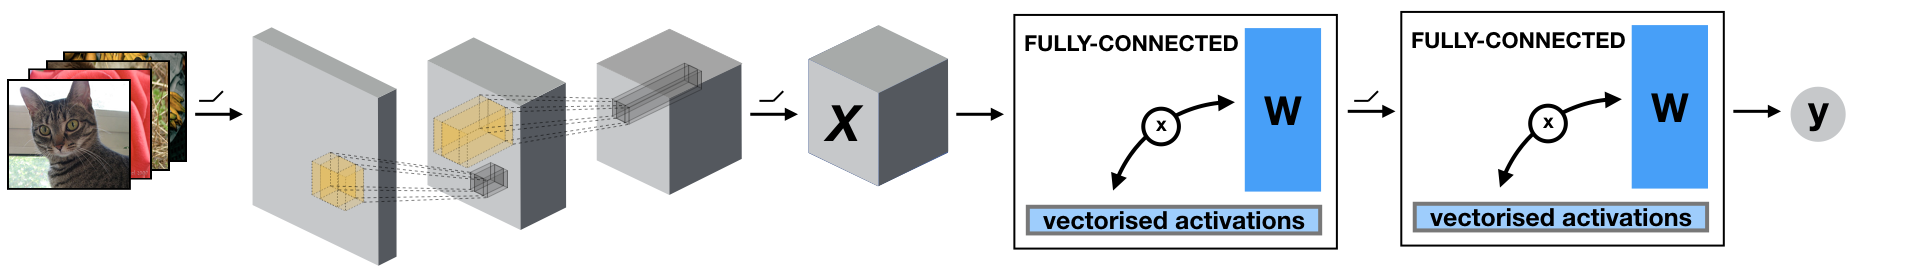

In [1]:
from IPython.display import Image, display
display(Image(filename='../images/FC.png', embed=True))

For instance, a typical architecture would be defined, in Gluon as follows:

```python
num_fc = 512
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))            
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    
    # The Flatten layer discards the multi-dimensional structure
    net.add(gluon.nn.Flatten())
    
    # fully-connected layers require a large number of parameters
    net.add(gluon.nn.Dense(num_fc))
    net.add(gluon.nn.Activation(activation='relu'))
    net.add(gluon.nn.Dense(num_outputs))
```

The idea of tensor regression layers is to instead leverage the spatial structure in the activation tensor
and formulate the output as lying in a low-rank subspace that jointly models the input and the output. This is done by means of a low-rank tensor regression.

The architecture corresponding to the previous one would be similar except that the Flatten layer and all fully-connected layers have been replaced by a Tensor Regression Layer:

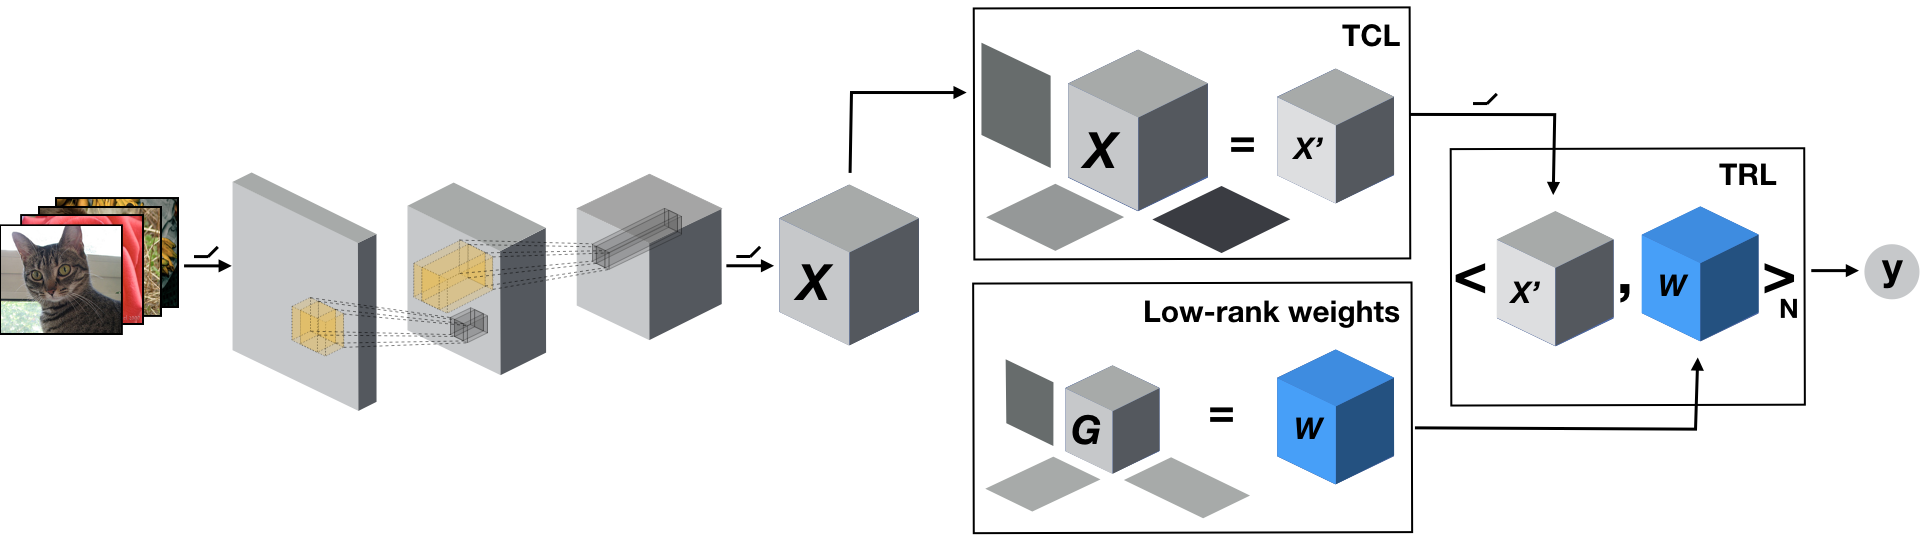

In [2]:
display(Image(filename='../images/TRL.png', embed=True))

In code, this would look something like this:

```python
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))            
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # We keep a reference to the trl instance so we can refer to it later
    trl = TRL([10, 3, 3, 10], num_outputs)
    net.add(trl)
```

In this notebook, we will demonstrate how to implement easily the TRL using TensorLy and MXNet.

# Implementation with TensorLy and MXNet's Gluon

Fist, let's import all the needed functions

In [1]:
# Import MXNet with it's Gluon Interface
import mxnet as mx
from mxnet import nd, autograd
from mxnet.gluon import Block
from mxnet import gluon

import numpy as np

import tensorly as tl
from tensorly.tenalg.generalised_inner_product import inner
from tensorly.random import check_random_state

# Make the calculations reproducible
mx.random.seed(1)

/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
Using numpy backend.


## Set the backend and context

First, let's instruct TensorLy to use the MXNet backend to perform all computations.

In [2]:
tl.set_backend('mxnet')

Using mxnet backend.


With MXNet you can easily run your code on both (mutli-) CPU or GPU:

In [3]:
ctx = mx.cpu()

## Load the MNIST dataset

Here we simply load the MNIST dataset as a numpy array and split the training and testing into MXNet's NDArrayIter.

In [6]:
mnist = mx.test_utils.get_mnist()
batch_size = 16 # Small batch size for test
num_outputs = 10
train_data = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"], batch_size, shuffle=True)
test_data = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"], batch_size, shuffle=True)

## Define the Tensor Regression Layer as a gluon Block

We wrap the code needed to perform low-rank tensor regression into a Gluon block so we can connect it to a deep convolutional net.
Specifically, we define a new Tensor Regression Layer (TRL), as defined in the paper, that can be incorporated in any exising architecture. 

In [7]:
class TRL(Block):
    def __init__(self, ranks, n_outputs, in_shape=0, verbose=1, **kwargs):
        super(TRL, self).__init__(**kwargs)
        with self.name_scope():
            self.ranks = tuple(ranks)
            self.n_outputs = n_outputs
            self.weight_initializer = mx.init.Xavier(magnitude=2.24)
            # Next we define a low-rank regression tensor, here in the Tucker form
            # Core of the Tucker tensor
            self.core = self.params.get(
                'core', init=self.weight_initializer, 
                 shape=self.ranks)
            # Factors of the Tucker tensors
            # First the factors corresponding to the input...
            self.factors = [self.params.get(
                'factor_{}'.format(i), init=self.weight_initializer,
                 allow_deferred_init=True,
                 shape=(0, e)) for (i, e) in enumerate(ranks[:-1])]
            # And the factors corresponding to the outputs
            self.factors.append(self.params.get(
                'factor_{}'.format(len(ranks) - 1), init=self.weight_initializer,
                 shape=(n_outputs, ranks[-1])))
            # Optional: add a bias term to the regression
            self.bias = self.params.get('bias', shape=(1, n_outputs))
            self.initialised_factors = False
            self.verbose = verbose
            self.displayed_info = False

    def forward(self, x):
        """This is where the actual computation is done
        """
        if not self.initialised_factors:
            if self.verbose:
                print('TRL: initializing factors') 
            for i in range(len(self.ranks) - 1):
                self.factors[i].shape = (x.shape[i+1], self.ranks[i])
                self.factors[i]._finish_deferred_init()
            self.initialised_factors = True
            if self.verbose:
                print('  ..done.')
        
        if self.verbose and not self.displayed_info:
            print('TRL on input of shape={} with batch size={}.'.format(
                            x.shape[1:], x.shape[0], self.n_outputs))
            print('    TRL-rank={} corresponding to ({} [inputs], {} [outputs])'.format(
                            self.core.shape, x.shape[1:], self.n_outputs))
            self.displayed_info = True
            
        with x.context:
            regression_weights = tl.tucker_to_tensor(self.core.data(), [f.data() for f in self.factors])
            result = inner(x, regression_weights, n_modes=x.ndim - 1)
            temp = nd.dot(x.reshape((0, -1)), nd.reshape(regression_weights, (-1, self.n_outputs)))

            return nd.broadcast_add(result, self.bias.data())
        
    def penalty(self, order=2):
        """Penalty term for the TRL
        
        Parameters
        ----------
        order : int, default is 2
            order of the norm of the core and factors
        """
        penalty = tl.norm(self.core.data(), order)
        for f in self.factors:
            penatly = penalty + tl.norm(f.data(), order)
        return penalty
    
    @property
    def regression_weights(self):
        """Convenience property to get the low-rank regression weights as a full tensor"""
        return tl.tucker_to_tensor(self.core.data(), [f.data() for f in self.factors])

## Define a Convolutional Net with a low-rank tensor regression output

Here, we define a simple Convolution Neural Network in which, instead of having a flattening + fully connected layer for output, we use a TRL:

In [8]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))            
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # We keep a reference to the trl instance so we can refer to it later
    trl = TRL([10, 3, 3, 10], num_outputs)
    net.add(trl)

Next, we initialise the parameters, as well as the optimiser.

In [9]:
# Collect the parameters of the model and randomly initialise them
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# We optimise the softmax cross entropy
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

# To optimise, we use a simple SGD
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

In [10]:
def evaluate_accuracy(data_iterator, net):
    """Evaluate the accuracy of the network
    """
    acc = mx.metric.Accuracy()
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

Finally, we are ready to run the actual optimisation loop: we loop through the training sample, and for each batch, update the weights of the network using gradient descent.

In [11]:
n_epoch = 5 # Number of epochs
smoothing_constant = .01 # For the moving loss
rng = check_random_state(1) 
C = 0.001 # regularization term for the TRL

for e in range(n_epoch):
    train_data.reset()
    for i, batch in enumerate(train_data):
        # Data contains the images from MNIST
        data = batch.data[0].as_in_context(ctx)
        # Label contains the corresponding label (digit in the image)
        label = batch.label[0].as_in_context(ctx)
        
        # Record the computation to be able to backpropagate
        with autograd.record():
            # Our network outputs a prediction from the input images
            prediction = net(data)
            # We compute the loss between the true label and the prediction
            # We also add a penalty, as defined in the TRL layer
            loss = softmax_cross_entropy(prediction, label) + C*trl.penalty()
        
        # Backpropagate the gradients and update the parameters
        loss.backward()
        trainer.step(data.shape[0])
        
        current_loss = nd.mean(loss).asscalar()
        moving_loss = (current_loss if ((i == 0) and (e == 0)) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * current_loss)
    
    # Print some information about the state of the training
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))    

TRL: initializing factors
  ..done.
TRL on input of shape=(50, 4, 4) with batch size=16.
    TRL-rank=(10, 3, 3, 10) corresponding to ((50, 4, 4) [inputs], 10 [outputs])
Epoch 0. Loss: 0.0732791599949, Train_acc 0.96695, Test_acc 0.9675
Epoch 1. Loss: 0.043855340995, Train_acc 0.9833, Test_acc 0.9821
Epoch 2. Loss: 0.0371843213462, Train_acc 0.9875, Test_acc 0.9854
Epoch 3. Loss: 0.032219216553, Train_acc 0.982816666667, Test_acc 0.9796
Epoch 4. Loss: 0.0284939914293, Train_acc 0.988016666667, Test_acc 0.985


Wasn't that easy?? :D

Should you want to, you can explore the learned regression weights:

In [12]:
trl.regression_weights.shape

(50, 4, 4, 10)

Or even plot them...

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'True regression weights')

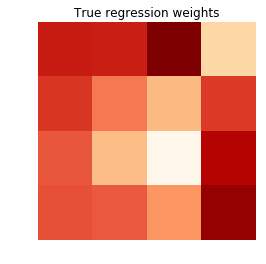

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
W = tl.to_numpy(trl.regression_weights)
ax.imshow(np.squeeze(W.mean(axis=0))[..., 0], cmap=plt.cm.OrRd, interpolation='nearest')
ax.set_axis_off()
ax.set_title('True regression weights')